In [1]:
library(rliger)
library(Seurat)
library(umap)
library(ggplot2)
library(reshape2)
library(Ckmeans.1d.dp)
set.seed(2021)
options(repr.plot.width=18, repr.plot.height=18)

Loading required package: cowplot

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix

Loading required package: patchwork


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [2]:
files = list.files(path = '/gpfs/ysm/home/bl666/HCL/Pseudo_Bulk',pattern = "*_updated.rds", full.names = TRUE)
tissue_list <- c("BM","CB","Kidney","Liver","Lung","PBMC")
YSG <- readRDS("/gpfs/ysm/pi/zhao-data/wd262/sc_immune/sc_immune/data/NSCLC/sg.list.rds")

In [3]:
seur.TPM_list <- list()
seur_list <- list()
for(i in seq(length(tissue_list))){
    seur <- readRDS(files[i]) ## counts
    seur <- NormalizeData(seur,normalization.method = "LogNormalize",scale.factor = 1000000)
    seur.TPM <- exp(GetAssayData(seur[['RNA']],slot='data'))-1
    seur.TPM_list[[i]] <- seur.TPM
    seur_list[[i]] <- seur
}
names(seur.TPM_list) <- tissue_list
names(seur_list)<- tissue_list

In [16]:
liger <- createLiger(seur.TPM_list) 
liger <- normalize(liger)
liger <- selectGenes(liger)
liger@var.genes <- intersect(YSG,liger@var.genes)

Removing 848 genes not expressing in BM.

Removing 1226 genes not expressing in CB.

Removing 1937 genes not expressing in Kidney.

Removing 1733 genes not expressing in Liver.

Removing 1392 genes not expressing in Lung.

Removing 804 genes not expressing in PBMC.



In [24]:
liger <- scaleNotCenter(liger)

In [26]:
for(i in seq(length(tissue_list))){
    liger@scale.data[[i]]  <- t(as.matrix(liger@norm.data[[i]][liger@var.genes,]))
}



In [27]:
liger <- optimizeALS(liger, k = 20)

  |======================================================================| 100%
Finished in 3.496743 mins, 30 iterations.
Max iterations set: 30.
Final objective delta: 0.0001765349.
Best results with seed 1.


In [29]:
liger <- quantile_norm(liger)
liger <- louvainCluster(liger, resolution = 0.25)

Louvain Clustering on quantile normalized cell factor loadings.



In [30]:
liger <- runTSNE(liger) 
liger <- runUMAP(liger)

In [32]:
saveRDS(liger,"/gpfs/ysm/pi/zhao-data/wd262/sc_immune/write/liger_obj/HCL_TPM.rds")

In [5]:
liger<-readRDS("/gpfs/ysm/pi/zhao-data/wd262/sc_immune/write/liger_obj/HCL_TPM.rds")

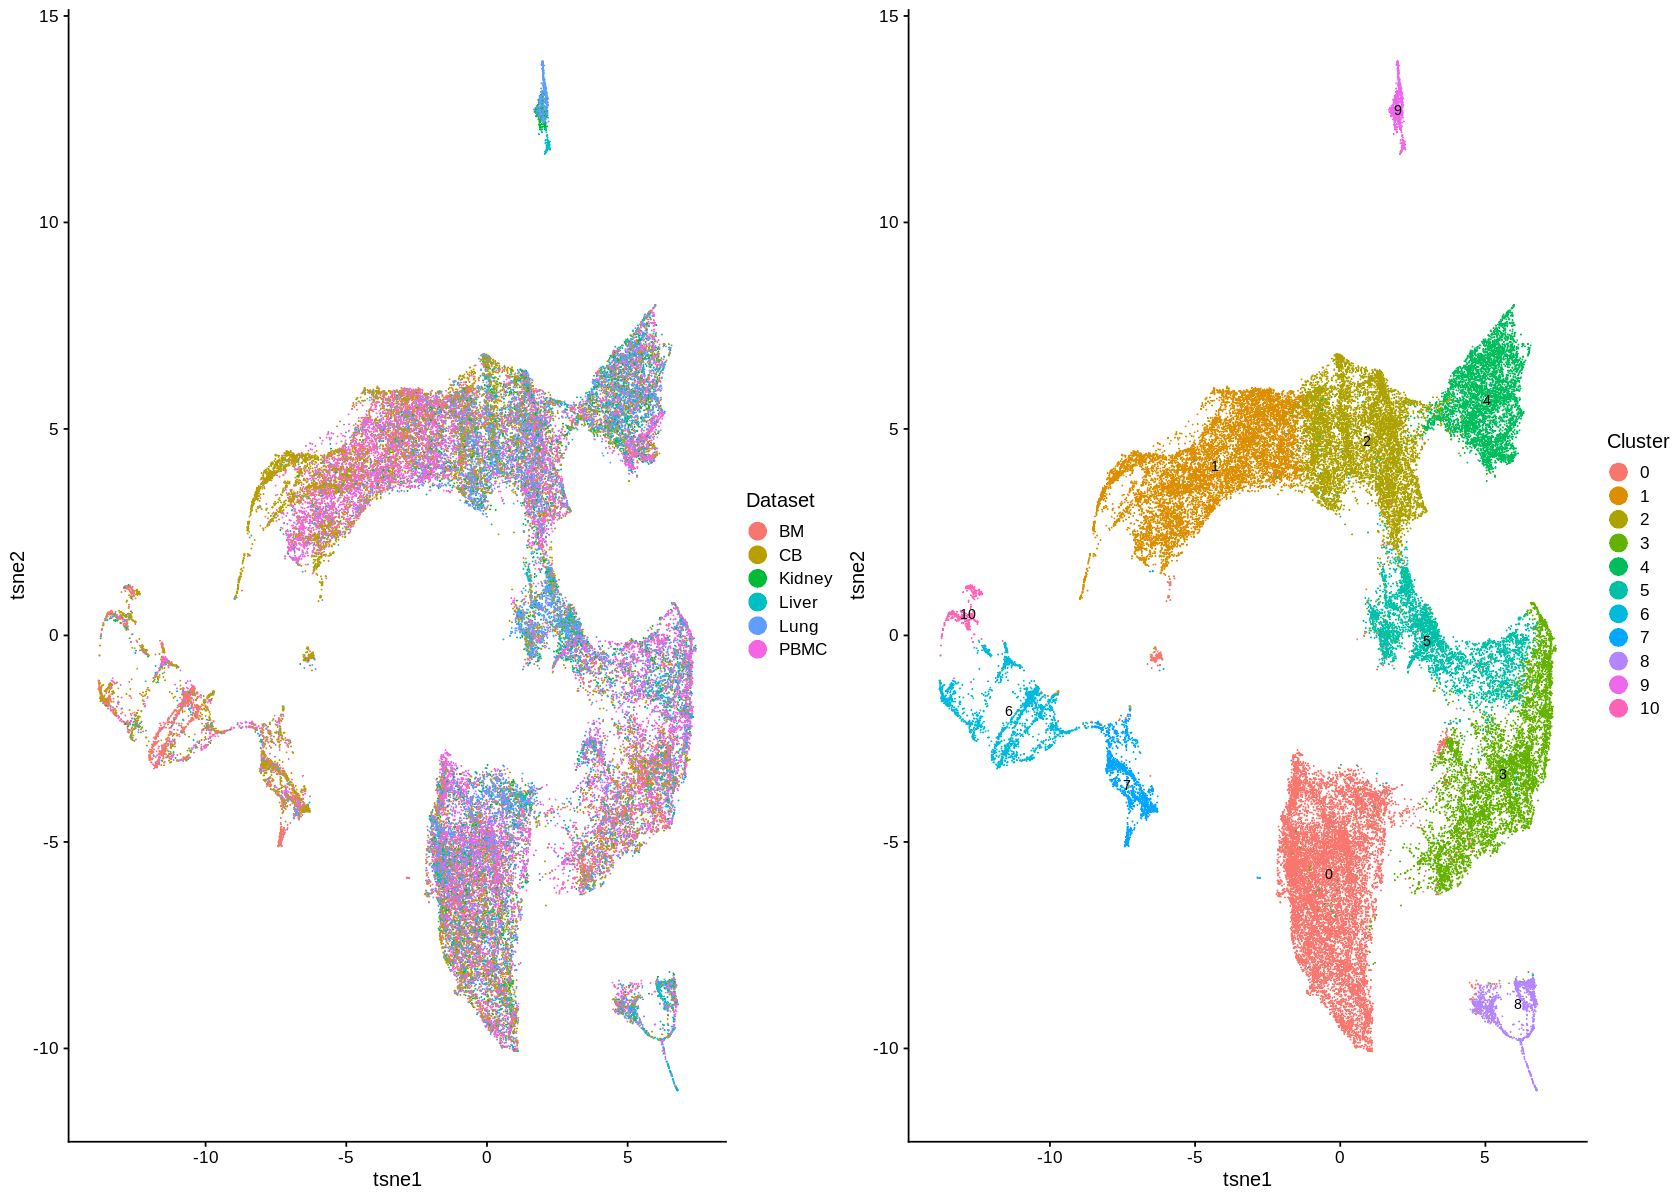

In [6]:
p <- plotByDatasetAndCluster(liger, return.plots = T)
plot_grid(p[[1]], p[[2]])

In [7]:
WH <- list()
WVH <- list()
mat <- list()

for(i in 1:6){
WH[[i]] <- t(liger@W)%*%t(liger@H.norm[colnames(seur.TPM_list[[i]]),])
#WH_PBMC <- t(ifnb_liger@W)%*%t(ifnb_liger@H$PBMC_HCL)
WVH[[i]]<- (t(liger@W)+t(liger@V[[1]]))%*%t(liger@H.norm[colnames(seur.TPM_list[[i]]),])
#WVH_PBMC<- (t(ifnb_liger@W)+t(ifnb_liger@V$PBMC_HCL))%*%t(ifnb_liger@H$PBMC_HCL)
mat[[i]] <- seur.TPM_list[[i]][liger@var.genes,]
mat[[i]] <- as.matrix(mat[[i]])
#idx.sample <- sample(seq(dim(mat[[i]])[1]*dim(mat[[i]])[2]),2000)
#plot(as.vector(WVH[[i]])[idx.sample],as.vector(mat[[i]])[idx.sample])
#plot(as.vector(WH[[i]])[idx.sample],as.vector(mat[[i]])[idx.sample])

#cor(as.vector(WVH[[i]])[idx.sample],as.vector(mat[[i]])[idx.sample])
#cor(as.vector(WH[[i]])[idx.sample],as.vector(mat[[i]])[idx.sample])
}

In [ ]:
new_mat <- Reduce(cbind,WH)

lst <- list()
for(i in seq(length(tissue_list))){
    lst[[i]] <- as.character(seur_list[[i]]$Celltype_used)
}
Celltype_used <-  Reduce(append,lst)

lst <- list()
for(i in seq(length(tissue_list))){
    lst[[i]] <- rep(tissue_list[i],ncol(seur_list[[i]]))
}
Batch <-  Reduce(append,lst)

In [ ]:
## visualization on W*H.norm
new_seur <- CreateSeuratObject(new_mat)
new_seur$Celltype_used <- Celltype_used
new_seur$Batch <- Batch

In [ ]:
## umap visualization
# standard log-normalization
new_seur <- NormalizeData(new_seur)
new_seur@assays$RNA@data <- new_seur@assays$RNA@counts
# choose ~1k variable features
new_seur <- FindVariableFeatures(new_seur, selection.method = "vst", nfeatures = 500)
# standard scaling (no regression)
new_seur <- ScaleData(new_seur)
# Run PCA, select 13 PCs for tSNE visualization and graph-based clustering
new_seur<- RunPCA(new_seur, verbose = FALSE)

new_seur <- FindNeighbors(new_seur, dims = 1:25)
new_seur <- FindClusters(new_seur, resolution = 0.8)
new_seur <- RunUMAP(new_seur, dims = 1:50)

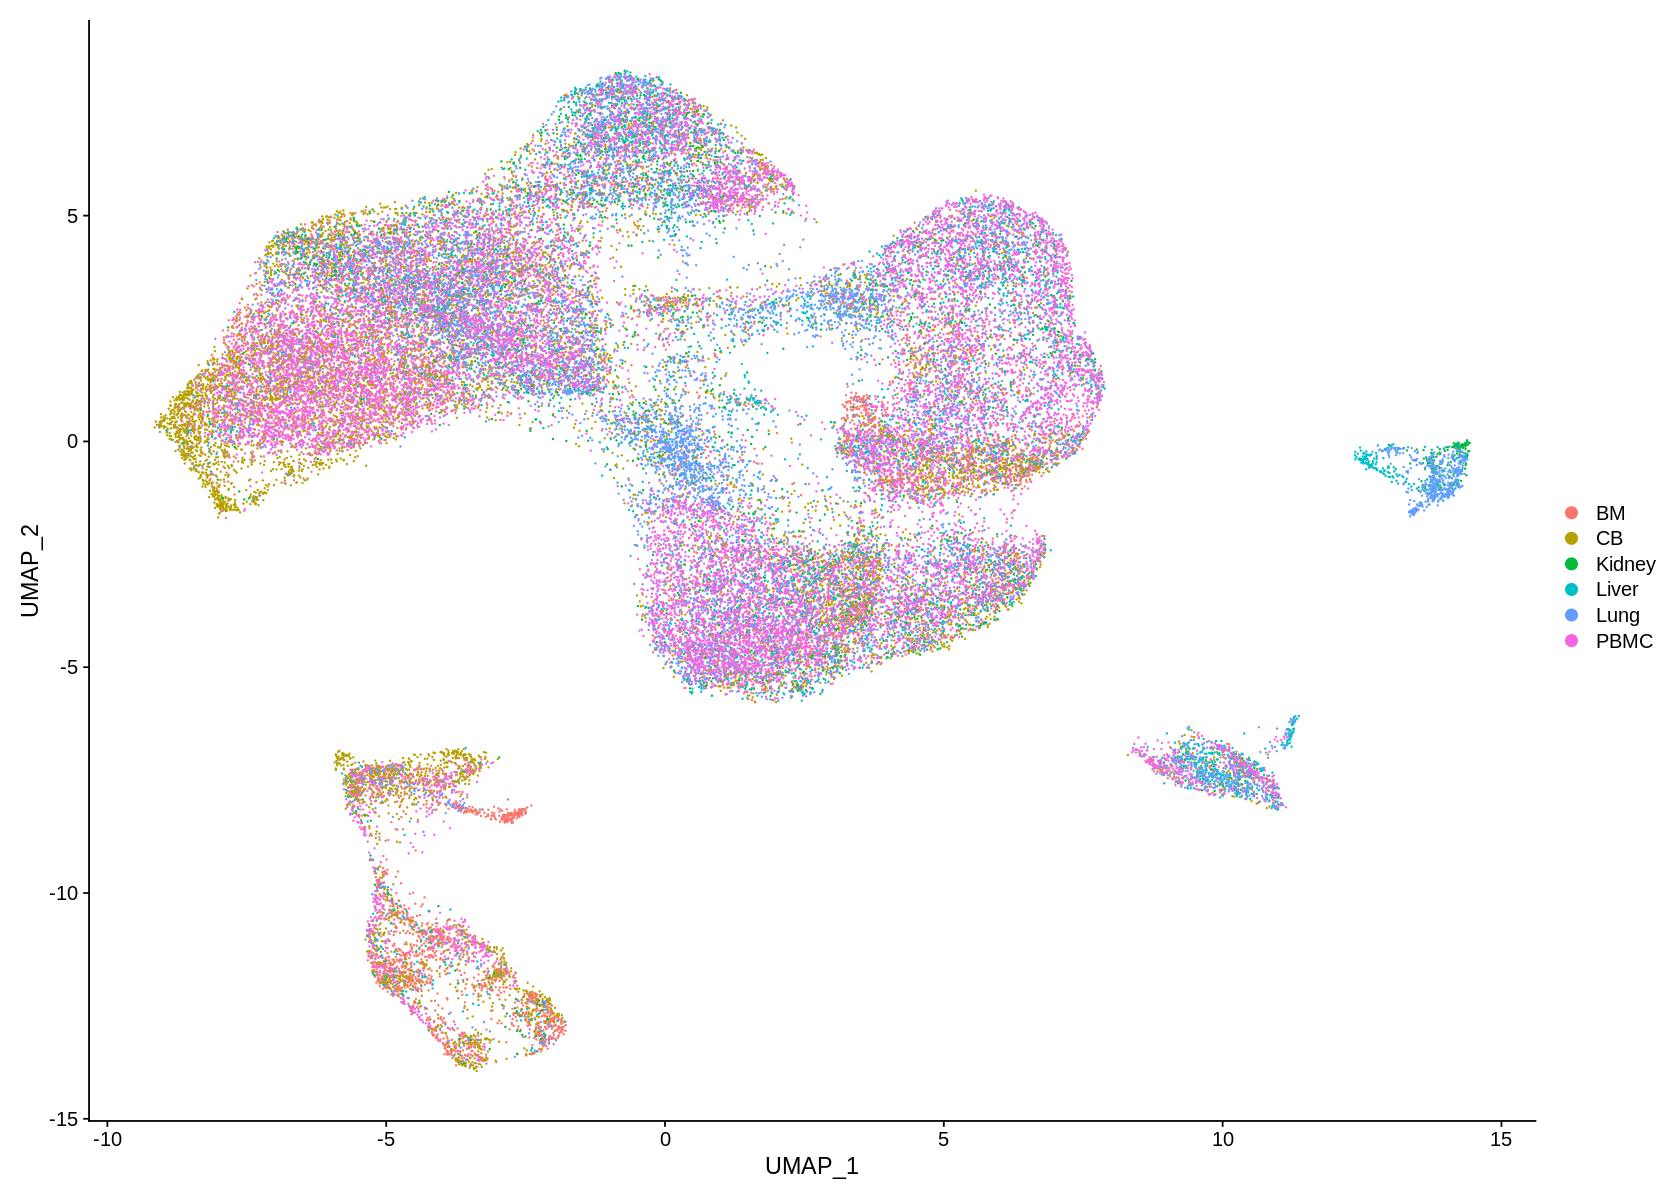

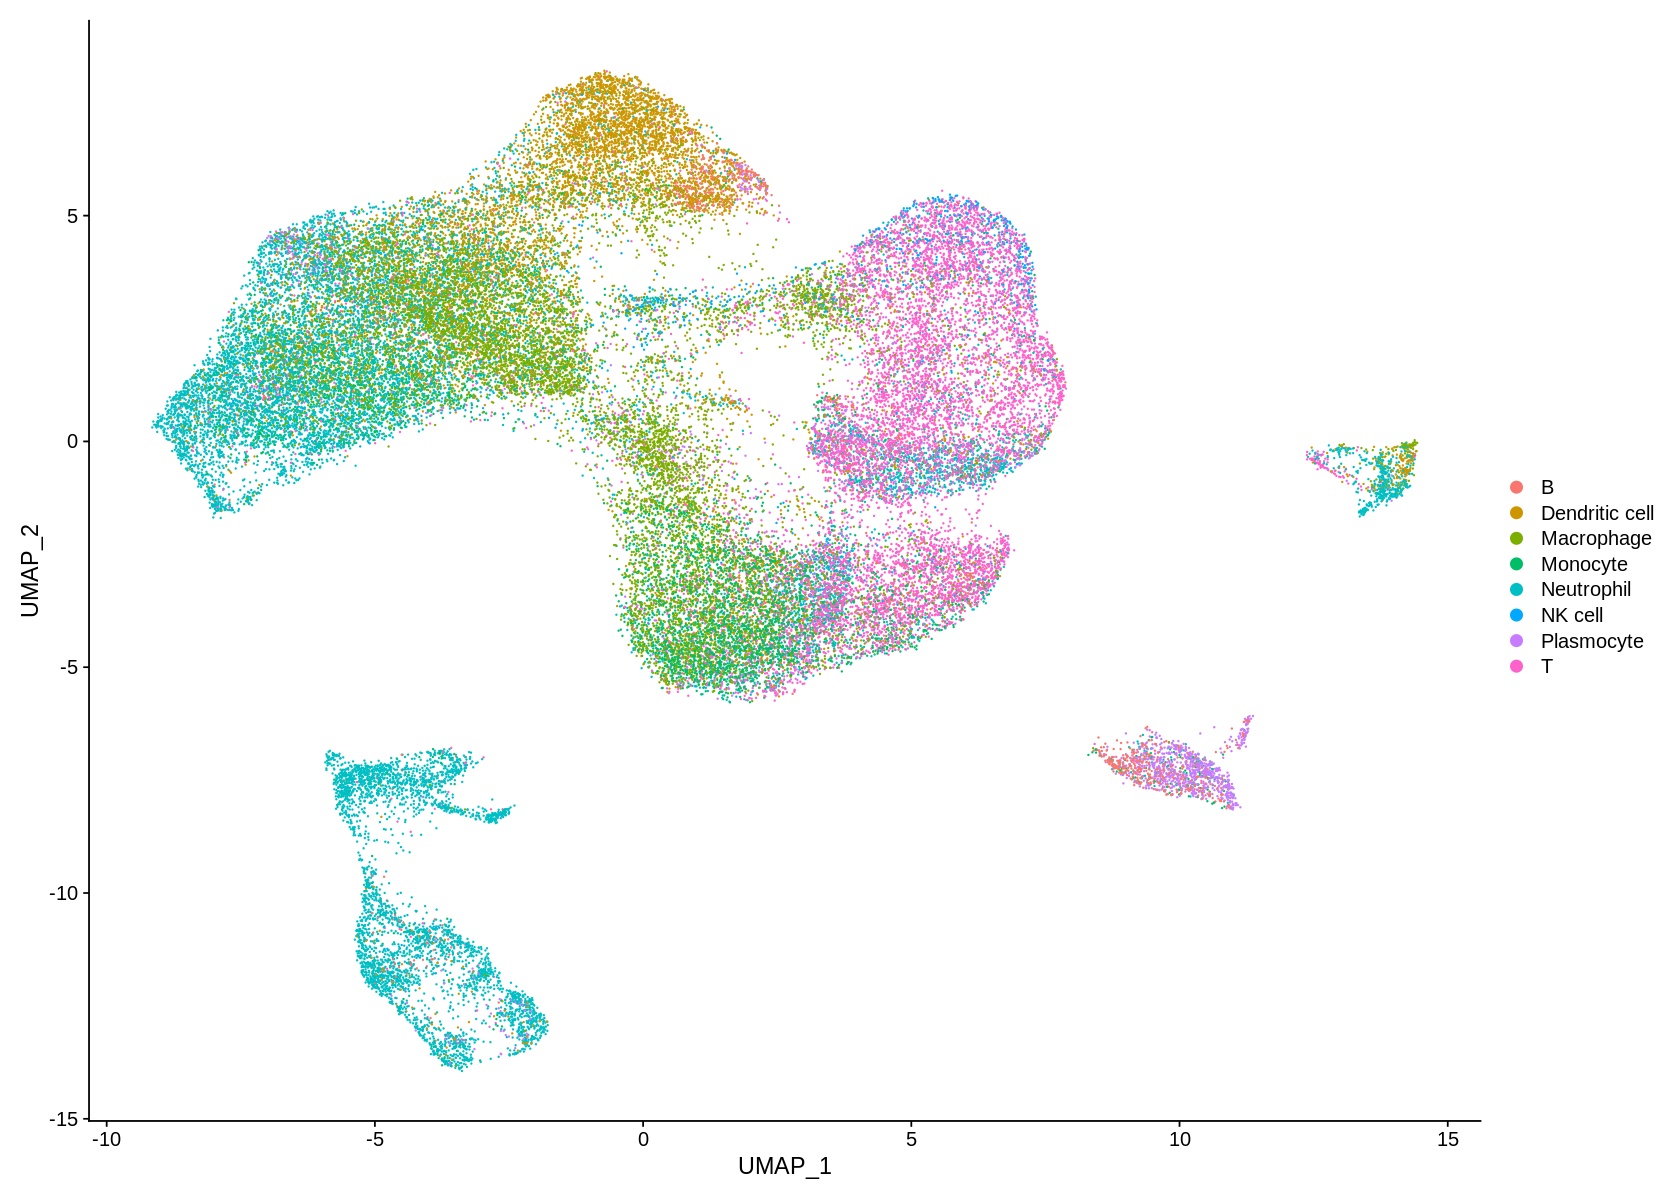

In [38]:
DimPlot(new_seur,group.by = 'Batch')
DimPlot(new_seur,group.by = 'Celltype_used')
#saveRDS(new_seur,"/gpfs/ysm/pi/zhao-data/wd262/sc_immune/write/liger_obj/BatchCorrected_HCL_seur.rds")

In [4]:
new_seur<-readRDS("/gpfs/ysm/pi/zhao-data/wd262/sc_immune/write/liger_obj/BatchCorrected_HCL_seur.rds")
new_split <- SplitObject(new_seur,split.by = 'Batch')

In [37]:
for(i in seq(length(tissue_list))){
    p1 <- DimPlot( new_split[[i]] , group.by='Celltype_used')+ ggtitle(paste0(tissue_list[i],", Batch Corrected"))
    p2 <- DimPlot( seur_list[[i]] , group.by='Celltype_used')+ ggtitle(paste0(tissue_list[i],", Raw"))
    plot_grid(p1, p2)
    ggsave(paste0('/gpfs/ysm/pi/zhao-data/wd262/sc_immune/plots/liger/cmp_',tissue_list[i],'.jpg',sep=''), width = 8, height = 4)
}

In [10]:
W_tilde <- list()

for(i in seq(length(tissue_list))){
    Idents(new_split[[i]]) <- "Celltype_used"
    new_split[[i]] <- NormalizeData(new_split[[i]])
    W_tilde[[i]] <- as.matrix(AverageExpression(new_split[[i]],slot='data')$RNA)
}

Finished averaging RNA for cluster Plasmocyte

Finished averaging RNA for cluster T

Finished averaging RNA for cluster B

Finished averaging RNA for cluster Macrophage

Finished averaging RNA for cluster Monocyte

Finished averaging RNA for cluster Neutrophil

Finished averaging RNA for cluster NK cell

Finished averaging RNA for cluster Dendritic cell

Finished averaging RNA for cluster Neutrophil

Finished averaging RNA for cluster Monocyte

Finished averaging RNA for cluster NK cell

Finished averaging RNA for cluster Dendritic cell

Finished averaging RNA for cluster T

Finished averaging RNA for cluster B

Finished averaging RNA for cluster Plasmocyte

Finished averaging RNA for cluster Macrophage

Finished averaging RNA for cluster T

Finished averaging RNA for cluster Dendritic cell

Finished averaging RNA for cluster B

Finished averaging RNA for cluster Plasmocyte

Finished averaging RNA for cluster Neutrophil

Finished averaging RNA for cluster Plasmocyte

Finished averaging

In [8]:

PlotCompare <- function(i,j){
    W_tilde_A <- W_tilde[[i]]
    W_tilde_B <- W_tilde[[j]]
    celltype.intersect <- intersect(colnames(W_tilde_A),colnames(W_tilde_B))
    df.cor1 <- melt(W_tilde_A[,celltype.intersect],value.name = "tissue1")
    df.cor2 <- melt(W_tilde_B[,celltype.intersect],value.name = "tissue2")
    df.cor <- cbind(df.cor1,tissue2=df.cor2[,3])
    return(df.cor)
}    


In [46]:
for(i in 1:5){
    for(j in (i+1):6){
       df.cor <- PlotCompare(i,j) 
       ggplot(df.cor,aes(x=tissue1,y=tissue2))+geom_point(aes(colour = factor(Var2)),size=.03)+
        xlab(tissue_list[i])+ylab(tissue_list[j])+coord_fixed(ratio = 1)+
        xlim(0,300)+ ylim(0,300) 
       ggsave(paste0('/gpfs/ysm/pi/zhao-data/wd262/sc_immune/plots/liger/cmp_2tissue/cmp_',tissue_list[i],"_",tissue_list[j],'.jpg',sep=''), width = 6, height = 3)

    }
}


Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 9 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 9 rows containing missing values (geom_point).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows cont

In [20]:
tissue_list

[1] "BM"     "CB"     "Kidney" "Liver"  "Lung"   "PBMC"

In [11]:
target_idx = 6
ref_idx = 2

df.cor <- PlotCompare(target_idx,ref_idx)
df.cor$ratio <- df.cor$tissue2/df.cor$tissue1

In [42]:
unique(df.cor$Var2)

[1] B              T              Monocyte       Dendritic cell Neutrophil    
[6] NK cell        Plasmocyte    
Levels: B T Monocyte Dendritic cell Neutrophil NK cell Plasmocyte

Warning message in cluster.1d.dp(x, k, y, method, estimate.k, "L2", deparse(substitute(x)), :
“Max number of clusters used. Consider increasing k!
”
Warning message:
“Removed 43 rows containing missing values (geom_point).”


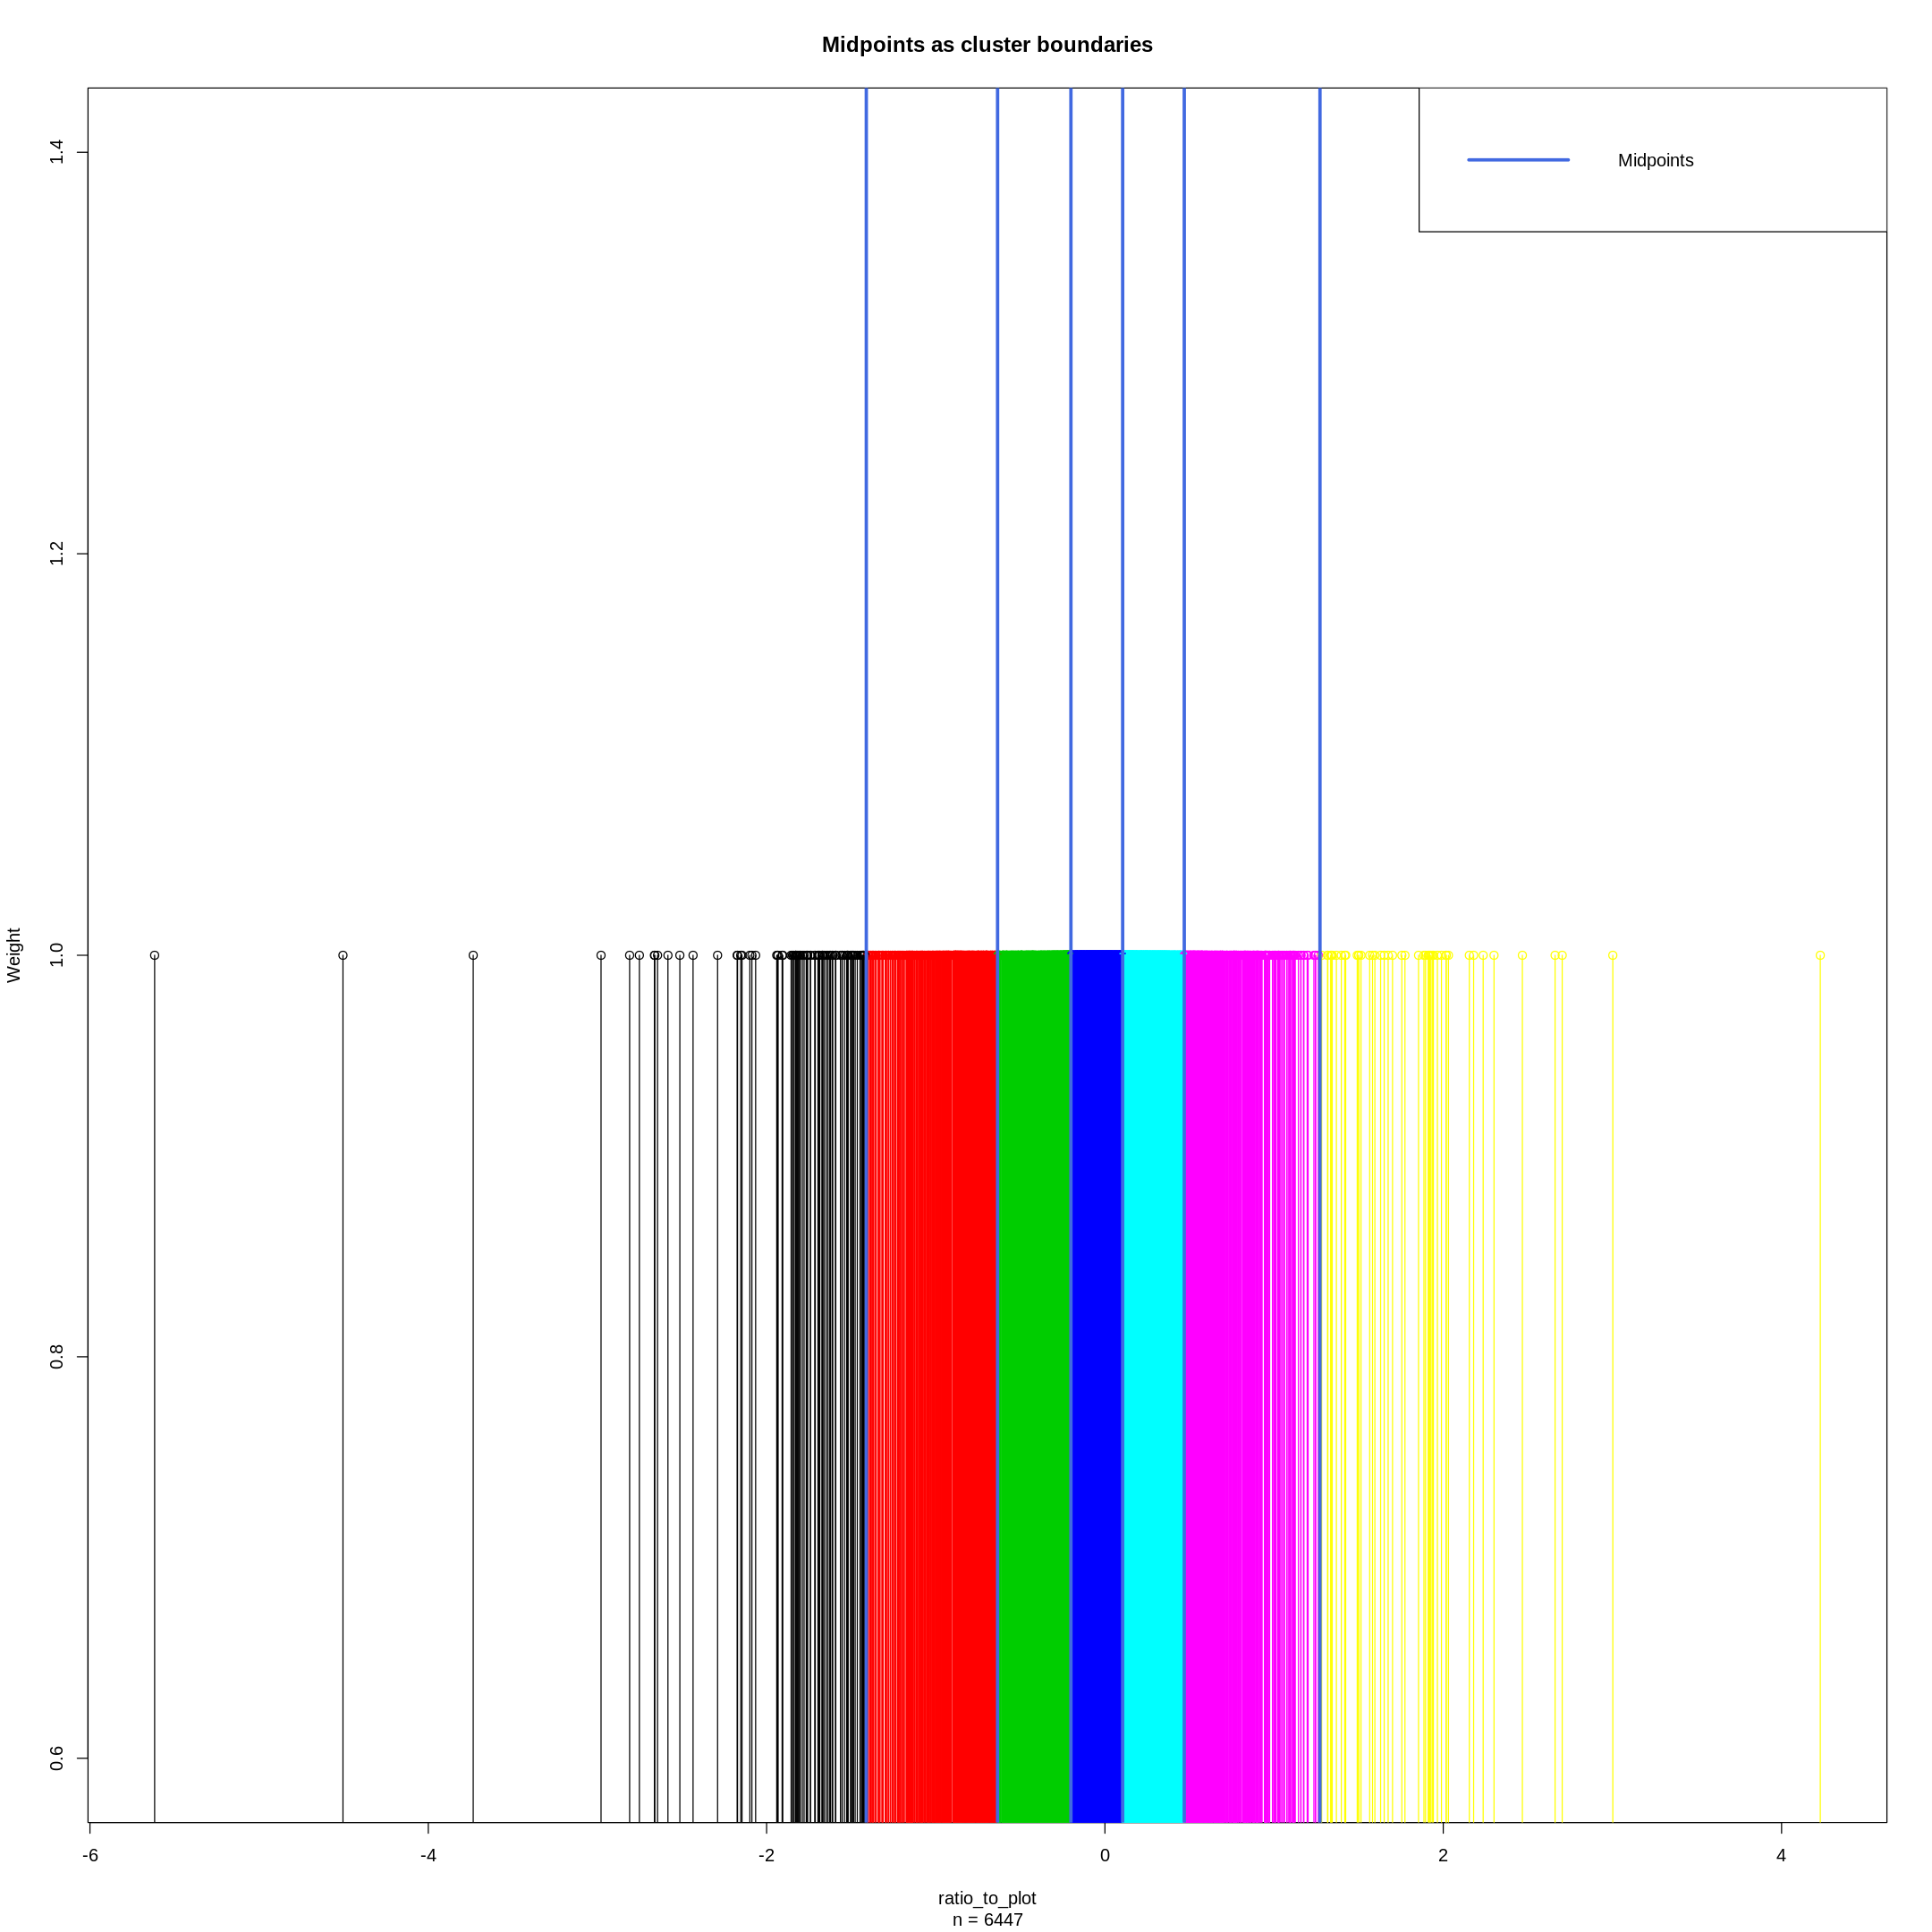

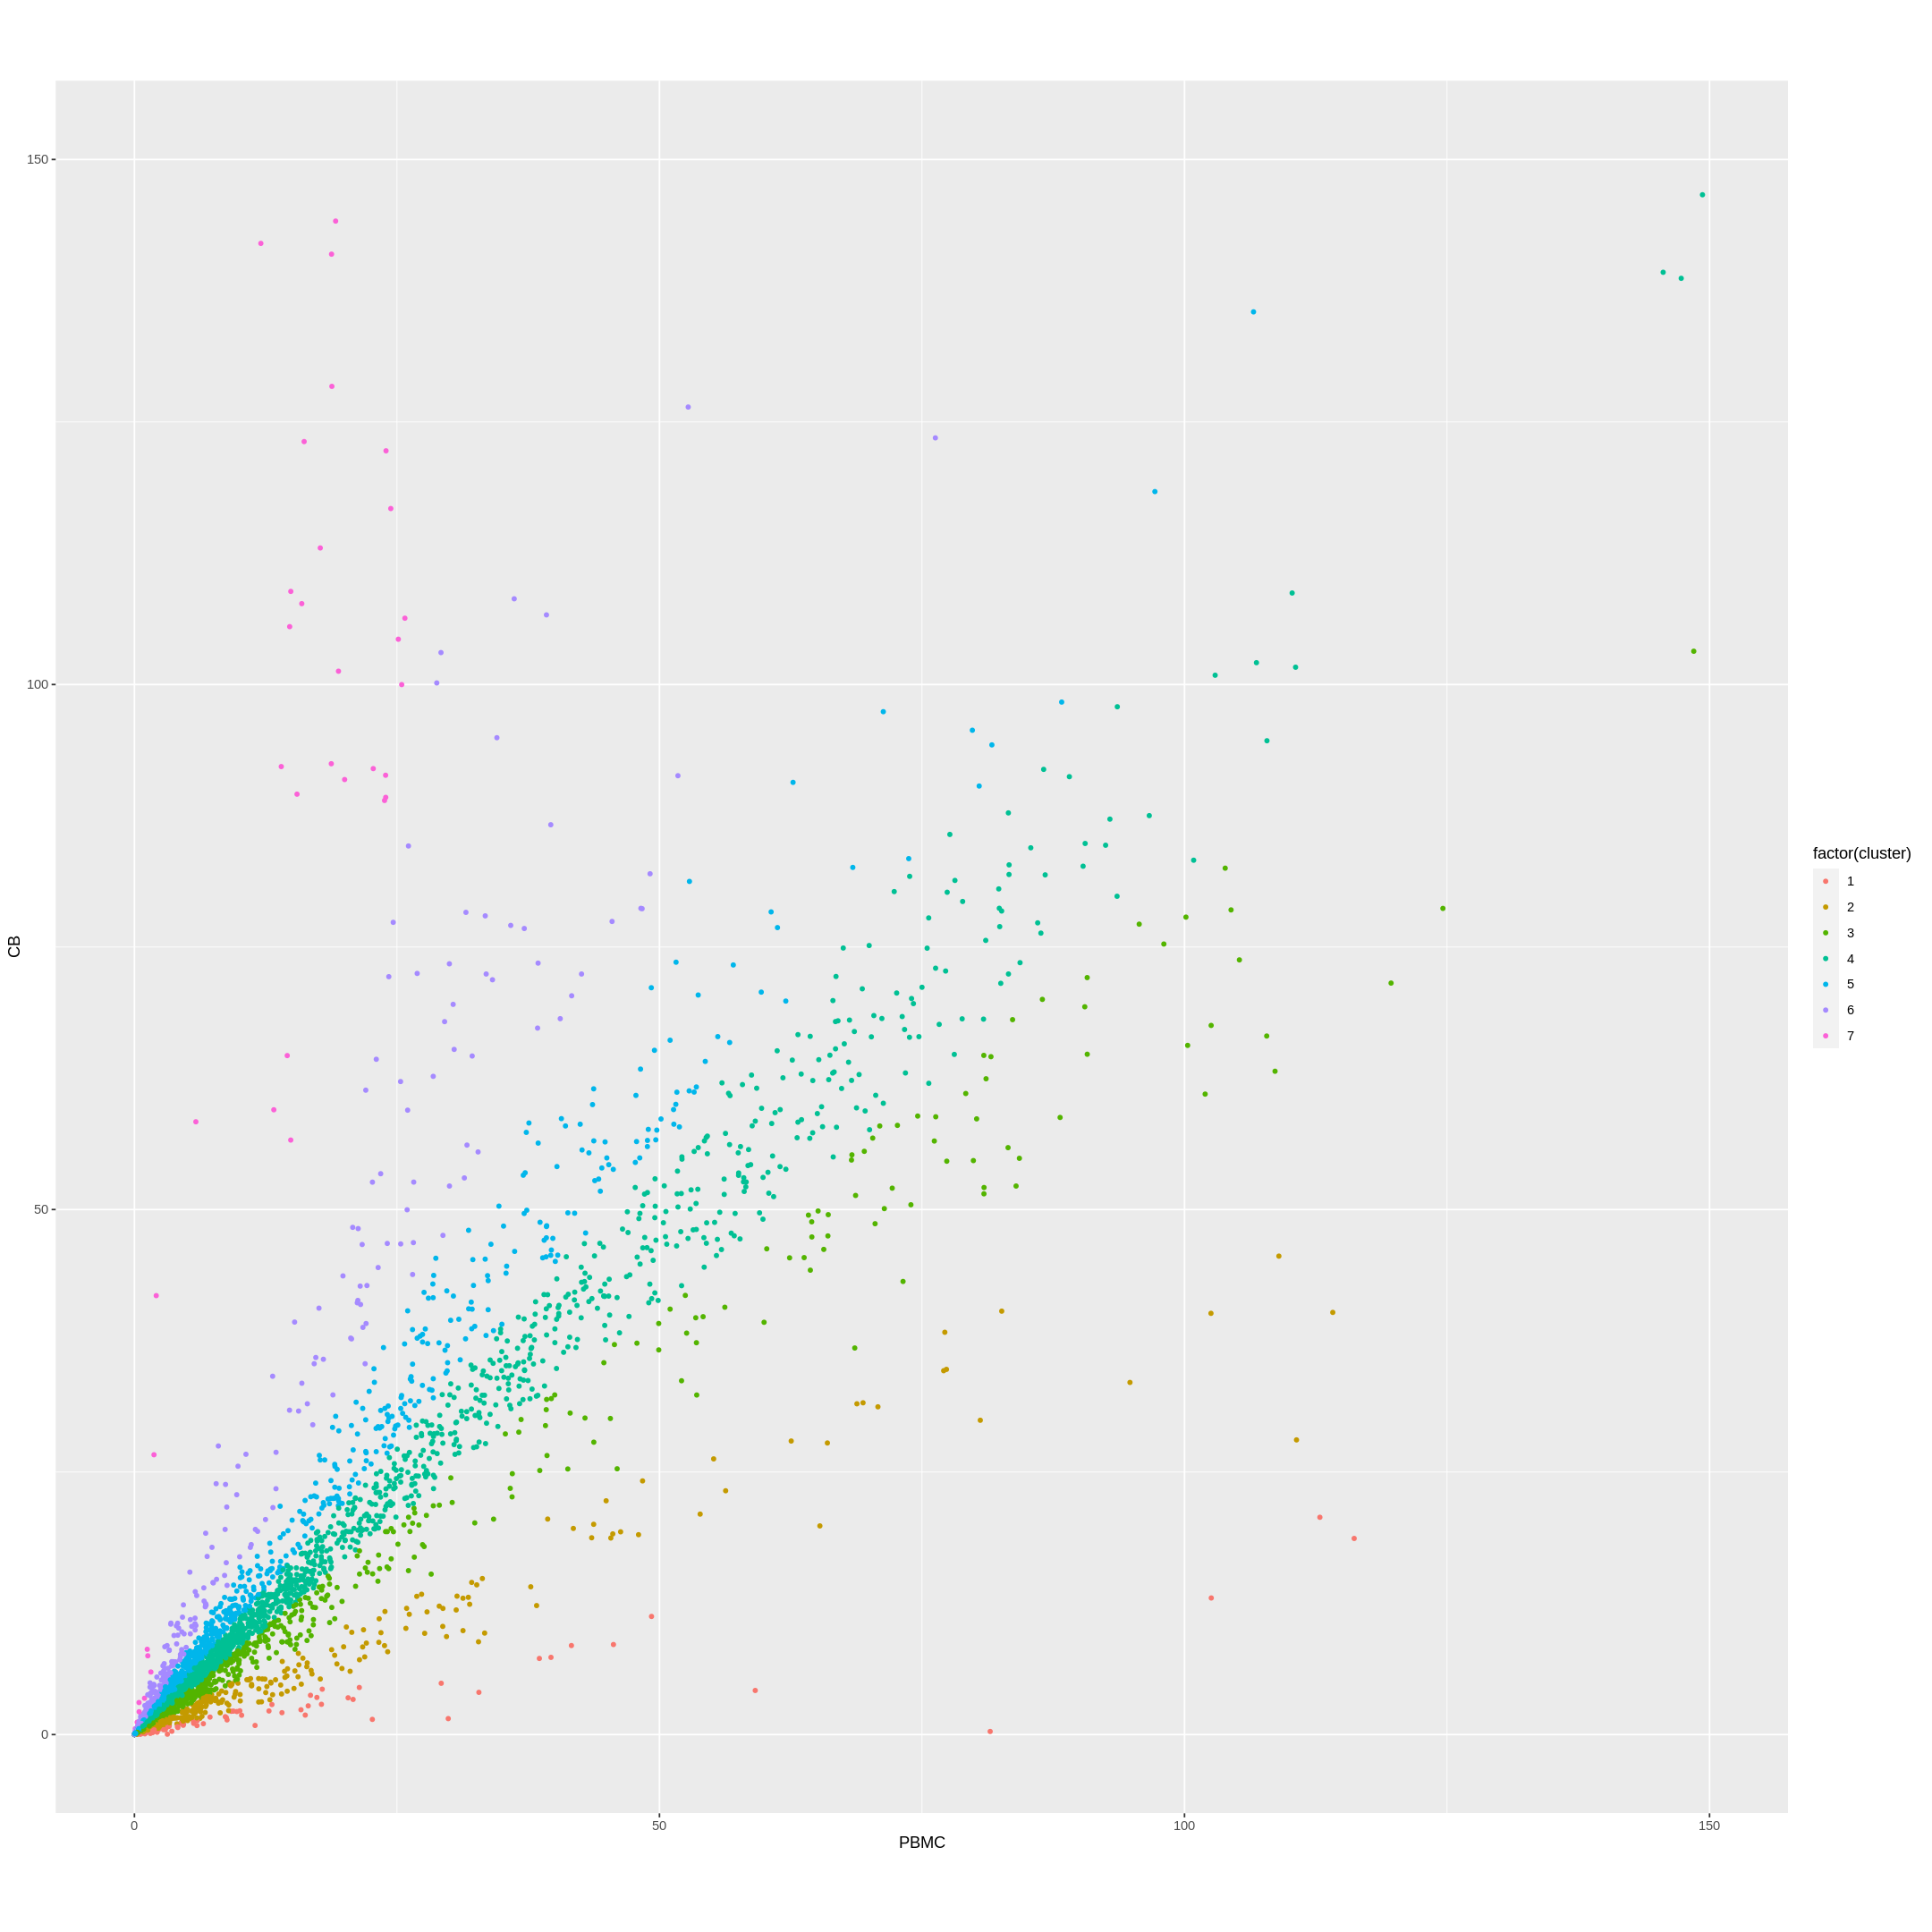

In [18]:
df.cor.plot <- df.cor[df.cor$Var2 %in% "Plasmocyte",]
df.cor.plot <- df.cor
ratio_to_plot <- log(df.cor.plot$ratio)
km <- Ckmeans.1d.dp(ratio_to_plot,k=c(3,7))
k=length(km$size)
midpoints <- ahist(km, style="midpoints", data=ratio_to_plot, plot=FALSE)$breaks[2:k]
df.cor.plot$cluster <- km$cluster

plot(km, main="Midpoints as cluster boundaries")
abline(v=midpoints, col="RoyalBlue", lwd=3)
legend("topright", "Midpoints", lwd=3, col="RoyalBlue")

ggplot(df.cor.plot,aes(x=tissue1,y=tissue2))+geom_point(aes(colour = factor(cluster)),size=1)+
        xlab(tissue_list[target_idx])+ylab(tissue_list[ref_idx])+coord_fixed(ratio = 1)+
        xlim(0,150)+ ylim(0,150) 

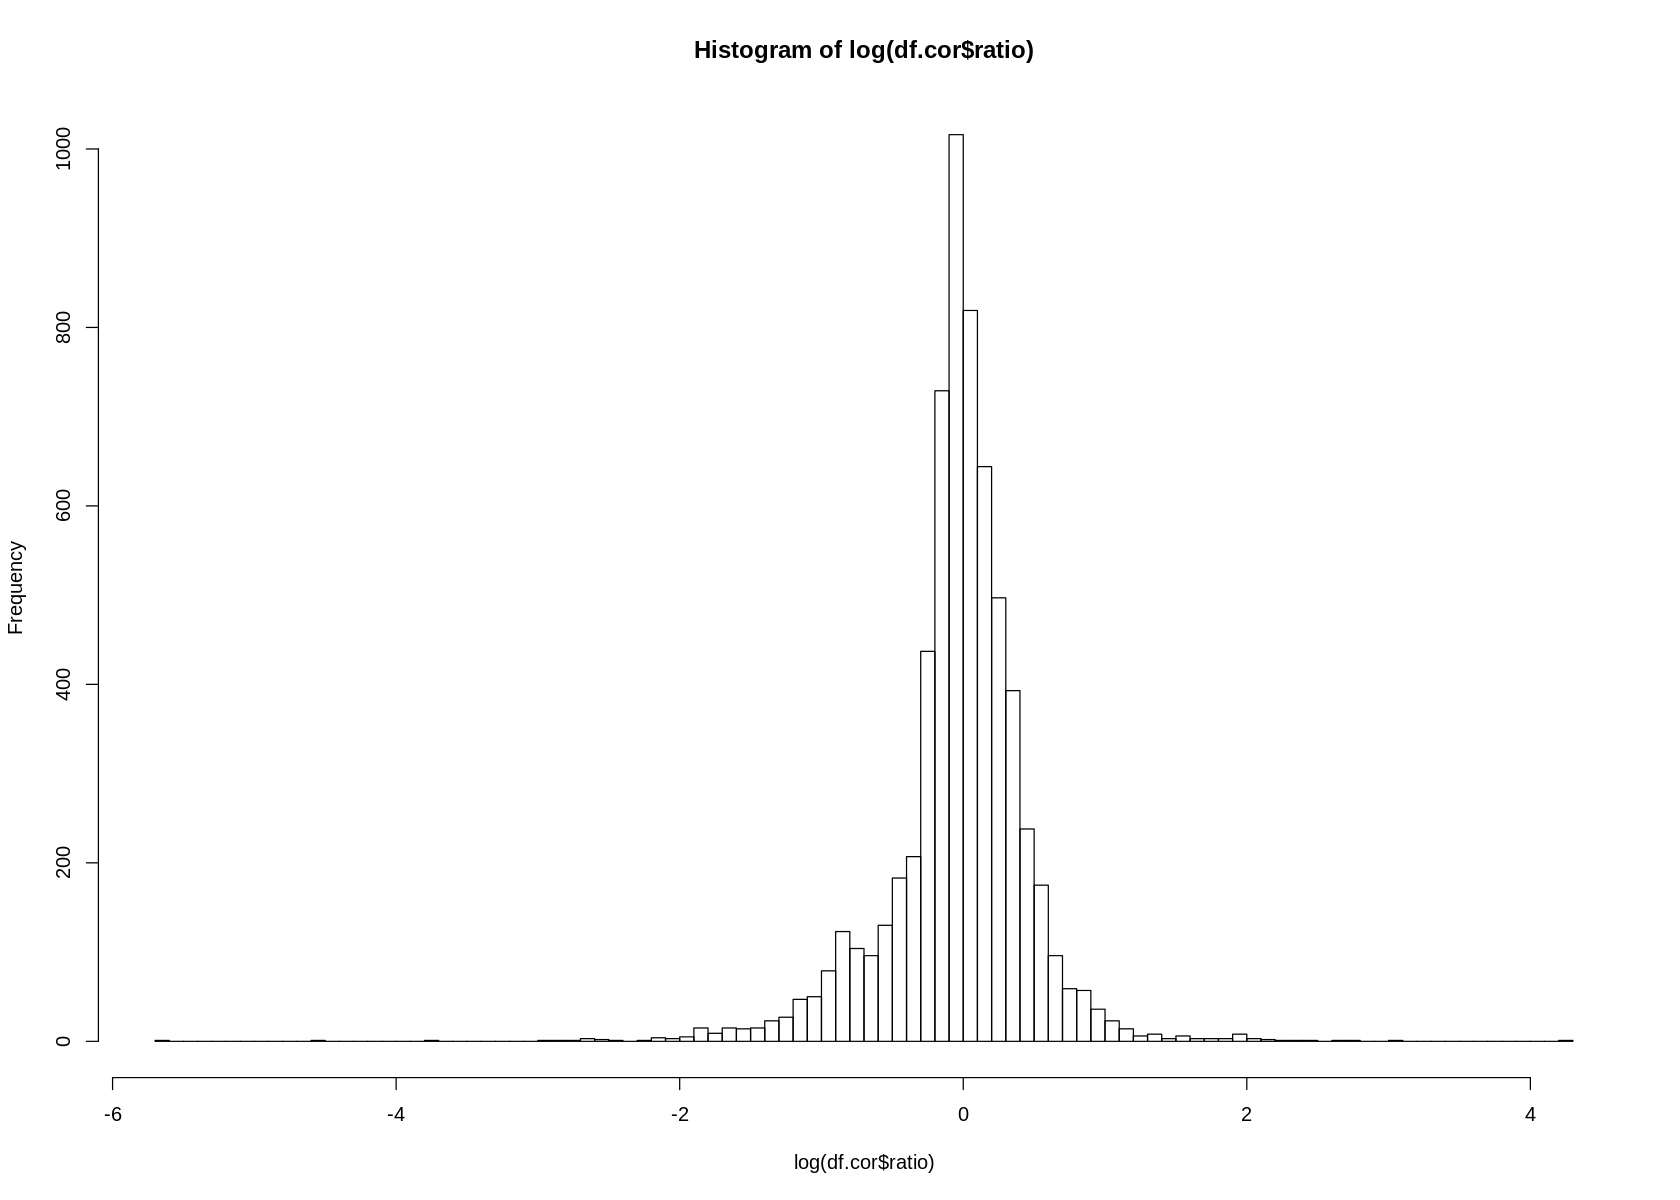

In [37]:
hist(log(df.cor$ratio),100)

[1] 0.2439836 0.5301452 0.8178604 1.1105175 1.5983665 3.5652989